# 8. 영화리뷰 텍스트 감성분석하기

|평가문항|상세기준|
|-------|-------|
|1. 다양한 방법으로 Text Classification 태스크를 성공적으로 구현하였다.|3가지 이상의 모델이 성공적으로 시도됨|
|2. gensim을 활용하여 자체학습된 혹은 사전학습된 임베딩 레이어를 분석하였다.|gensim의 유사단어 찾기를 활용하여 자체학습한 임베딩과 사전학습 임베딩을 비교 분석함|
|3. 한국어 Word2Vec을 활용하여 가시적인 성능향상을 달성했다.|네이버 영화리뷰 데이터 감성분석 정확도를 85% 이상 달성함|

In [1]:
import os
import pandas as pd
import numpy as np
import konlpy
import gensim
import tensorflow as tf
import matplotlib.pyplot as plt
from konlpy.tag import Mecab
from collections import Counter
from keras.utils import pad_sequences

print(konlpy.__version__)
print(gensim.__version__)

2023-04-18 18:15:28.714249: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-18 18:15:29.239558: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


0.6.0
3.7.3


In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


2023-04-18 18:15:30.030882: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-04-18 18:15:30.070436: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-04-18 18:15:30.070484: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-04-18 18:15:30.073357: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-04-18 18:15:30.073429: I tensorflow/compile

In [3]:
train_data = pd.read_table('./ratings_train.txt')
test_data = pd.read_table('./ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [4]:
test_data.head()

,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0


In [5]:
print(train_data.isnull().sum())
print(train_data.isnull().sum())

id          0
document    5
label       0
dtype: int64
id          0
document    5
label       0
dtype: int64


In [6]:
train_data.dropna(axis=0,inplace=True)
test_data.dropna(axis=0,inplace=True)

print(train_data.shape)
print(test_data.shape)

(149995, 3)
(49997, 3)


In [7]:
tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=None):
    X_train = []
    for sentence in train_data['document']:
        temp = tokenizer.morphs(sentence)
        temp = [word for word in temp if not word in stopwords]
        X_train.append(temp)

    X_test = []
    for sentence in test_data['document']:
        temp = tokenizer.morphs(sentence)
        temp = [word for word in temp if not word in stopwords]
        X_test.append(temp)

    # 단어 사전을 생성합니다.
    word_counts = Counter(np.concatenate(X_train))
    # 인덱스 0에는 패딩 토큰 <PAD>을, 인덱스 1에는 <UNK> 토큰을 추가합니다.
    index_to_word = ['<PAD>', '<UNK>'] + [word[0] for word in word_counts.most_common()]
    # 만약 num_words가 None이 아니면, 가장 빈도가 높은 num_words개만 선택합니다.
    if num_words is not None:
        index_to_word = index_to_word[:num_words]
    # 단어와 인덱스를 매핑하는 딕셔너리를 만듭니다.
    word_to_index = {word: index for index, word in enumerate(index_to_word)}

    # 데이터셋을 숫자로 변환합니다.
    # word_to_index 딕셔너리에서 해당 단어가 존재하지 않으면 <UNK> 토큰의 인덱스 1을 반환합니다.
    X_train = [[word_to_index.get(word, 1) for word in sentence] for sentence in X_train]
    X_test = [[word_to_index.get(word, 1) for word in sentence] for sentence in X_test]
    y_train = np.array(train_data['label'])
    y_test = np.array(test_data['label'])

    return X_train, y_train, X_test, y_test, word_to_index

num_words=20000
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data, num_words=num_words)

In [8]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

In [9]:
print(pd.DataFrame(X_train).shape)
print(y_train.shape)
print(pd.DataFrame(X_test).shape)
print(y_test.shape)

(149995, 116)
(149995,)
(49997, 105)
(49997,)


(array([7.2241e+04, 5.2510e+04, 1.1545e+04, 6.2820e+03, 4.6550e+03,
        2.5570e+03, 1.9400e+02, 7.0000e+00, 1.0000e+00, 3.0000e+00]),
 array([  0. ,  11.6,  23.2,  34.8,  46.4,  58. ,  69.6,  81.2,  92.8,
        104.4, 116. ]),
 <BarContainer object of 10 artists>)

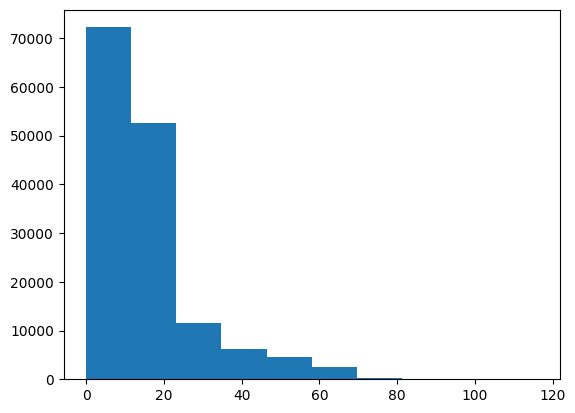

In [10]:
X_train_len=[len(sentence) for sentence in X_train]
plt.hist(X_train_len)

(array([2.1739e+04, 1.7390e+04, 5.4650e+03, 2.1920e+03, 1.5280e+03,
        1.2780e+03, 3.7600e+02, 2.7000e+01, 1.0000e+00, 1.0000e+00]),
 array([  0. ,  10.5,  21. ,  31.5,  42. ,  52.5,  63. ,  73.5,  84. ,
         94.5, 105. ]),
 <BarContainer object of 10 artists>)

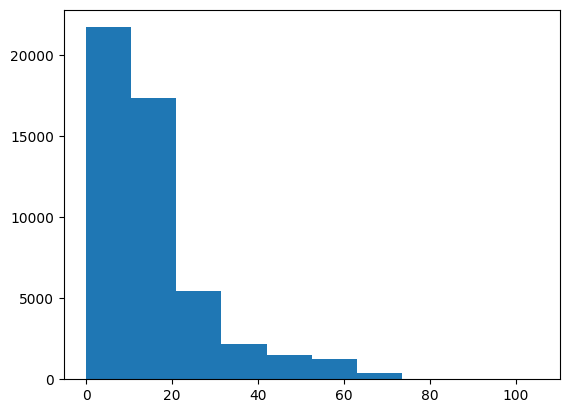

In [11]:
X_test_len=[len(sentence) for sentence in X_test]
plt.hist(X_test_len)

In [12]:
maxlen = 120  # 문장 최대 길이
X_train_pad = pad_sequences(X_train, maxlen=maxlen, padding='pre')
X_test_pad = pad_sequences(X_test, maxlen=maxlen, padding='pre')
print(pd.DataFrame(X_test_pad).shape)
print(X_train_pad[:5])

(49997, 120)
[[    0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0    30    72   919     2     2    37   228    18    31   750]
 [    0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     

In [13]:
index_to_word = {index:word for word, index in word_to_index.items()}
get_decoded_sentence(X_train_pad[0],index_to_word)

'<PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> 아 더 빙 . . 진짜 짜증 나 네요 목소리'

In [14]:
train_data.loc[0]

id                      9976970
document    아 더빙.. 진짜 짜증나네요 목소리
label                         0
Name: 0, dtype: object

In [15]:
X_train_pad[0]

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,  30,  72, 919,   2,   2,  37, 228,
        18,  31, 750], dtype=int32)

In [16]:
X_train[0]

[30, 72, 919, 2, 2, 37, 228, 18, 31, 750]

In [17]:
index_to_word[30]

'아'

데이터의 전처리가 완료되었으므로 모델을 만들어서 학습을 시작한다.  
이때 모델은 총 4개로 테스트를 해본다.  

모델1: CNN  
모델2: Dense  
모델3: RNN  
모델4: LSTM  

In [18]:
word_vector_dim = 200   # 단어 하나를 표현하는 임베딩 벡터의 차원 수입니다. 

model1 = tf.keras.Sequential()
model1.add(tf.keras.layers.Embedding(num_words, word_vector_dim, input_shape=(maxlen,)))
model1.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model1.add(tf.keras.layers.MaxPooling1D(5))
model1.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model1.add(tf.keras.layers.GlobalMaxPooling1D())
model1.add(tf.keras.layers.Dense(8, activation='relu'))
model1.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 120, 200)          4000000   
                                                                 
 conv1d (Conv1D)             (None, 114, 16)           22416     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 22, 16)           0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 16, 16)            1808      
                                                                 
 global_max_pooling1d (Globa  (None, 16)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 8)                 1

In [19]:
model2 = tf.keras.Sequential()
model2.add(tf.keras.layers.Embedding(num_words, word_vector_dim, input_shape=(maxlen,)))
model2.add(tf.keras.layers.GlobalMaxPooling1D())
model2.add(tf.keras.layers.Dense(8, activation='relu'))
model2.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 120, 200)          4000000   
                                                                 
 global_max_pooling1d_1 (Glo  (None, 200)              0         
 balMaxPooling1D)                                                
                                                                 
 dense_2 (Dense)             (None, 8)                 1608      
                                                                 
 dense_3 (Dense)             (None, 1)                 9         
                                                                 
Total params: 4,001,617
Trainable params: 4,001,617
Non-trainable params: 0
_________________________________________________________________


In [20]:
model3 = tf.keras.Sequential()
model3.add(tf.keras.layers.Embedding(num_words, word_vector_dim, input_shape=(maxlen,)))
model3.add(tf.keras.layers.MaxPooling1D(5))
model3.add(tf.keras.layers.SimpleRNN(128))
model3.add(tf.keras.layers.Dense(64, activation='relu'))
model3.add(tf.keras.layers.Reshape((64, 1)))
model3.add(tf.keras.layers.SimpleRNN(32))
model3.add(tf.keras.layers.Dense(16, activation='relu'))
model3.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 120, 200)          4000000   
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 24, 200)          0         
 1D)                                                             
                                                                 
 simple_rnn (SimpleRNN)      (None, 128)               42112     
                                                                 
 dense_4 (Dense)             (None, 64)                8256      
                                                                 
 reshape (Reshape)           (None, 64, 1)             0         
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 32)                1088      
                                                      

In [21]:
model4 = tf.keras.Sequential()
model4.add(tf.keras.layers.Embedding(num_words, word_vector_dim, input_shape=(maxlen,)))
model4.add(tf.keras.layers.MaxPooling1D(5))
model4.add(tf.keras.layers.LSTM(128))
model4.add(tf.keras.layers.Dense(64, activation='relu'))
model4.add(tf.keras.layers.Reshape((64, 1)))
model4.add(tf.keras.layers.LSTM(32))
model4.add(tf.keras.layers.Dense(16, activation='relu'))
model4.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model4.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 120, 200)          4000000   
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 24, 200)          0         
 1D)                                                             
                                                                 
 lstm (LSTM)                 (None, 128)               168448    
                                                                 
 dense_7 (Dense)             (None, 64)                8256      
                                                                 
 reshape_1 (Reshape)         (None, 64, 1)             0         
                                                                 
 lstm_1 (LSTM)               (None, 32)                4352      
                                                      

2023-04-18 18:15:49.932658: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-18 18:15:49.933969: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-18 18:15:49.934913: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

                                                                 
Total params: 4,181,601
Trainable params: 4,181,601
Non-trainable params: 0
_________________________________________________________________


In [22]:
model1.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model1.fit(X_train_pad,
                    y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_split=0.2,
                    verbose=1)

Epoch 1/20


2023-04-18 18:15:51.660274: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8801
2023-04-18 18:15:52.433896: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-04-18 18:15:52.441069: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x55ddc1f9fa60 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-04-18 18:15:52.441100: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): NVIDIA GeForce RTX 3080, Compute Capability 8.6
2023-04-18 18:15:52.444800: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-04-18 18:15:52.547669: I ./tensorflow/compiler/jit/device_compiler.h:180] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the p

235/235 [==============================] - 29s 107ms/step - loss: 0.5406 - accuracy: 0.7048 - val_loss: 0.4614 - val_accuracy: 0.7682
Epoch 2/20
235/235 [==============================] - 11s 48ms/step - loss: 0.4130 - accuracy: 0.7966 - val_loss: 0.4566 - val_accuracy: 0.7693
Epoch 3/20
235/235 [==============================] - 8s 35ms/step - loss: 0.3463 - accuracy: 0.8342 - val_loss: 0.4656 - val_accuracy: 0.7708
Epoch 4/20
235/235 [==============================] - 5s 21ms/step - loss: 0.2728 - accuracy: 0.8692 - val_loss: 0.5136 - val_accuracy: 0.7643
Epoch 5/20
235/235 [==============================] - 4s 19ms/step - loss: 0.2129 - accuracy: 0.8940 - val_loss: 0.5931 - val_accuracy: 0.7617
Epoch 6/20
235/235 [==============================] - 4s 18ms/step - loss: 0.1748 - accuracy: 0.9099 - val_loss: 0.6768 - val_accuracy: 0.7581
Epoch 7/20
235/235 [==============================] - 5s 20ms/step - loss: 0.1517 - accuracy: 0.9180 - val_loss: 0.7634 - val_accuracy: 0.7562
Epoch 8

In [23]:
results1 = model1.evaluate(X_test_pad,  y_test, verbose=2)

print(results1)

1563/1563 - 6s - loss: 1.4585 - accuracy: 0.7369 - 6s/epoch - 4ms/step
[1.4585267305374146, 0.7369242310523987]


In [24]:
history_dict = history.history
print(history_dict.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


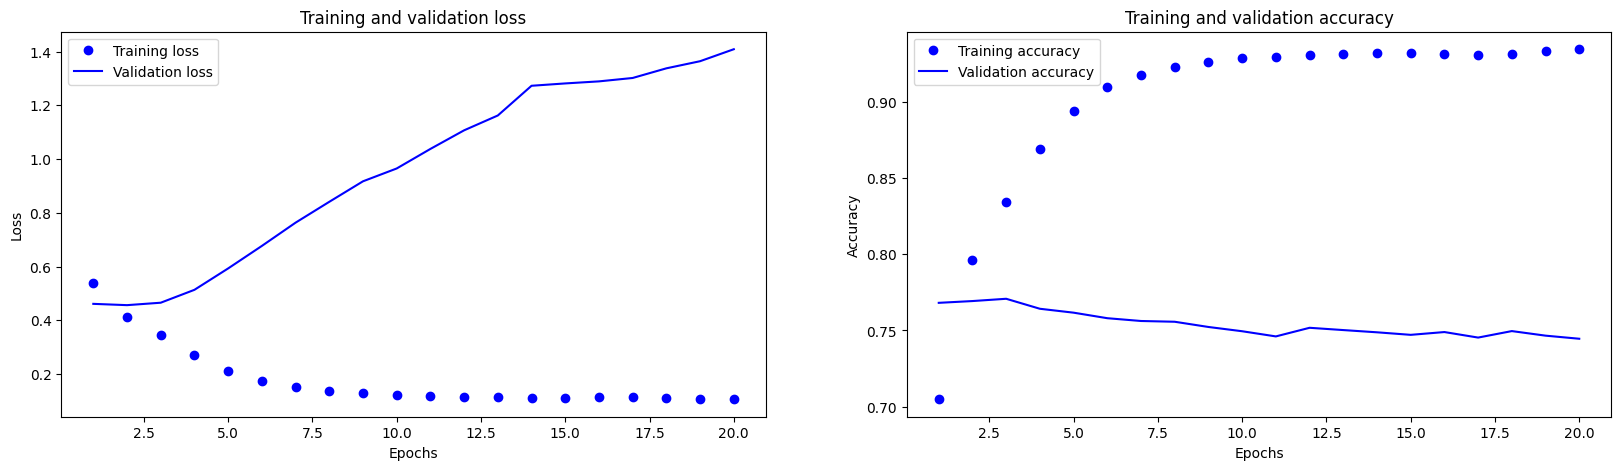

In [25]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
plt.figure(figsize=(20,5))
# "bo"는 "파란색 점"입니다
plt.subplot(1,2,1)
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs, acc, 'bo', label='Training accuracy')
# b는 "파란 실선"입니다
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [26]:
model2.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model2.fit(X_train_pad,
                    y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_split=0.2,
                    verbose=1)

Epoch 1/20
235/235 [==============================] - 21s 85ms/step - loss: 0.4511 - accuracy: 0.8104 - val_loss: 0.3433 - val_accuracy: 0.8502
Epoch 2/20
235/235 [==============================] - 10s 43ms/step - loss: 0.2959 - accuracy: 0.8767 - val_loss: 0.3296 - val_accuracy: 0.8609
Epoch 3/20
235/235 [==============================] - 6s 27ms/step - loss: 0.2387 - accuracy: 0.9053 - val_loss: 0.3375 - val_accuracy: 0.8599
Epoch 4/20
235/235 [==============================] - 4s 19ms/step - loss: 0.1906 - accuracy: 0.9287 - val_loss: 0.3562 - val_accuracy: 0.8568
Epoch 5/20
235/235 [==============================] - 3s 13ms/step - loss: 0.1459 - accuracy: 0.9494 - val_loss: 0.3842 - val_accuracy: 0.8559
Epoch 6/20
235/235 [==============================] - 4s 16ms/step - loss: 0.1065 - accuracy: 0.9667 - val_loss: 0.4215 - val_accuracy: 0.8505
Epoch 7/20
235/235 [==============================] - 3s 13ms/step - loss: 0.0751 - accuracy: 0.9789 - val_loss: 0.4637 - val_accuracy: 0.84

In [27]:
results2 = model2.evaluate(X_test_pad,  y_test, verbose=2)

print(results2)

1563/1563 - 4s - loss: 0.8127 - accuracy: 0.8375 - 4s/epoch - 3ms/step
[0.812694787979126, 0.837530255317688]


In [28]:
history_dict = history.history
print(history_dict.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


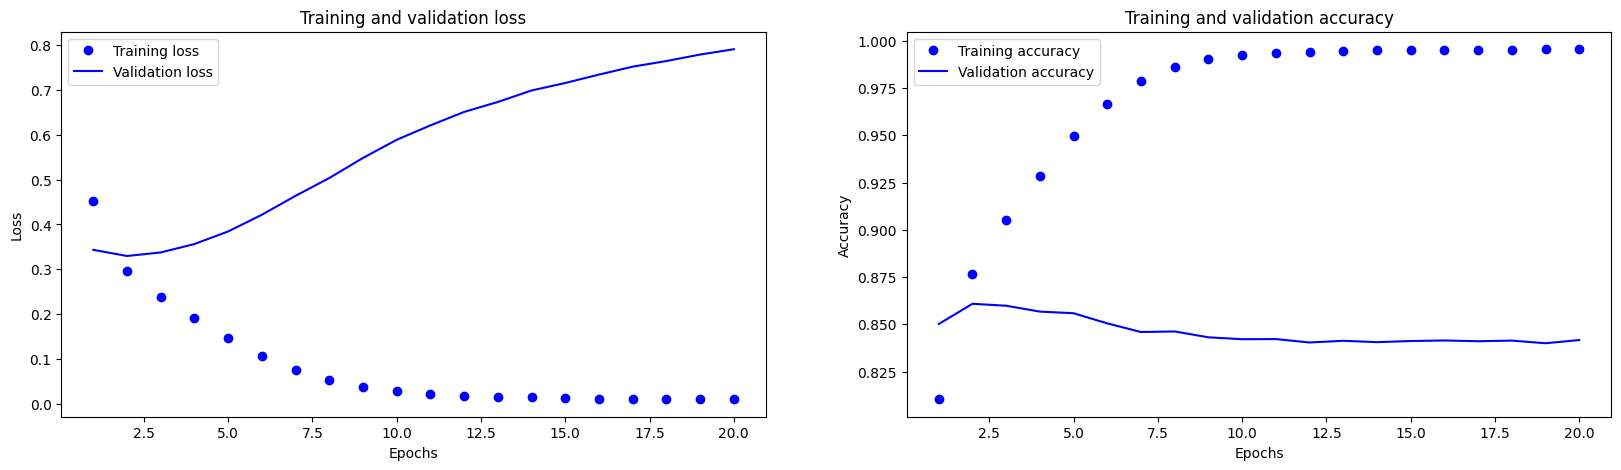

In [29]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
plt.figure(figsize=(20,5))
# "bo"는 "파란색 점"입니다
plt.subplot(1,2,1)
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs, acc, 'bo', label='Training accuracy')
# b는 "파란 실선"입니다
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [30]:
model3.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model3.fit(X_train_pad,
                    y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_test_pad, y_test),
                    verbose=1)

Epoch 1/20
293/293 [==============================] - 65s 215ms/step - loss: 0.4072 - accuracy: 0.8035 - val_loss: 0.3335 - val_accuracy: 0.8550
Epoch 2/20
293/293 [==============================] - 53s 180ms/step - loss: 0.2545 - accuracy: 0.8984 - val_loss: 0.3429 - val_accuracy: 0.8551
Epoch 3/20
293/293 [==============================] - 48s 165ms/step - loss: 0.1685 - accuracy: 0.9369 - val_loss: 0.4128 - val_accuracy: 0.8440
Epoch 4/20
293/293 [==============================] - 48s 165ms/step - loss: 0.1112 - accuracy: 0.9605 - val_loss: 0.4858 - val_accuracy: 0.8421
Epoch 5/20
293/293 [==============================] - 47s 161ms/step - loss: 0.0849 - accuracy: 0.9706 - val_loss: 0.5120 - val_accuracy: 0.8370
Epoch 6/20
293/293 [==============================] - 47s 160ms/step - loss: 0.0659 - accuracy: 0.9773 - val_loss: 0.5962 - val_accuracy: 0.8363
Epoch 7/20
293/293 [==============================] - 47s 161ms/step - loss: 0.0491 - accuracy: 0.9828 - val_loss: 0.6861 - val_ac

In [31]:
results3 = model3.evaluate(X_test_pad,  y_test, verbose=2)

print(results3)

1563/1563 - 33s - loss: 0.9907 - accuracy: 0.8290 - 33s/epoch - 21ms/step
[0.990653395652771, 0.8290497660636902]


In [32]:
history_dict = history.history
print(history_dict.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


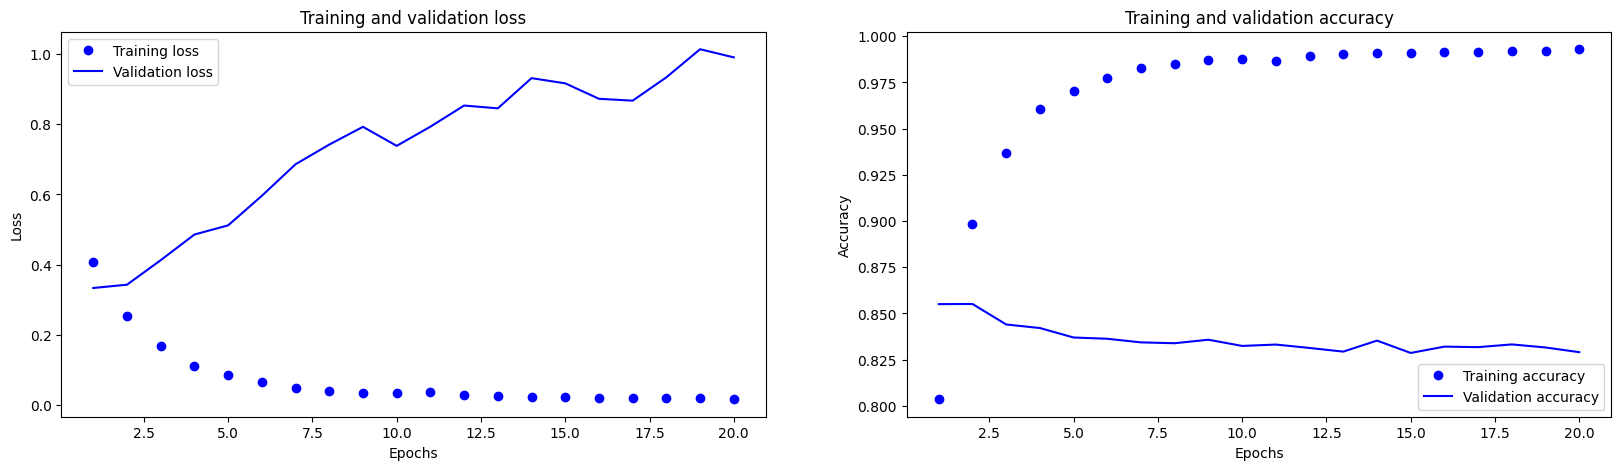

In [33]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
plt.figure(figsize=(20,5))
# "bo"는 "파란색 점"입니다
plt.subplot(1,2,1)
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs, acc, 'bo', label='Training accuracy')
# b는 "파란 실선"입니다
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [34]:
model4.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model4.fit(X_train_pad,
                    y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_test_pad, y_test),
                    verbose=1)

Epoch 1/20


2023-04-18 18:35:43.773213: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-18 18:35:43.774466: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-18 18:35:43.775603: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

292/293 [============================>.] - ETA: 0s - loss: 0.4168 - accuracy: 0.7976

2023-04-18 18:36:09.502697: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-18 18:36:09.503893: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-18 18:36:09.504891: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

293/293 [==============================] - 27s 82ms/step - loss: 0.4164 - accuracy: 0.7979 - val_loss: 0.3421 - val_accuracy: 0.8520
Epoch 2/20
293/293 [==============================] - 11s 38ms/step - loss: 0.2718 - accuracy: 0.8888 - val_loss: 0.3310 - val_accuracy: 0.8586
Epoch 3/20
293/293 [==============================] - 7s 23ms/step - loss: 0.2033 - accuracy: 0.9218 - val_loss: 0.3573 - val_accuracy: 0.8559
Epoch 4/20
293/293 [==============================] - 7s 24ms/step - loss: 0.1417 - accuracy: 0.9483 - val_loss: 0.4053 - val_accuracy: 0.8517
Epoch 5/20
293/293 [==============================] - 5s 19ms/step - loss: 0.0976 - accuracy: 0.9664 - val_loss: 0.4927 - val_accuracy: 0.8470
Epoch 6/20
293/293 [==============================] - 6s 19ms/step - loss: 0.0739 - accuracy: 0.9756 - val_loss: 0.5044 - val_accuracy: 0.8480
Epoch 7/20
293/293 [==============================] - 5s 17ms/step - loss: 0.0570 - accuracy: 0.9808 - val_loss: 0.6448 - val_accuracy: 0.8459
Epoch 8/

In [35]:
results4 = model4.evaluate(X_test_pad,  y_test, verbose=2)

print(results4)

1563/1563 - 9s - loss: 0.8717 - accuracy: 0.8403 - 9s/epoch - 6ms/step
[0.8716568946838379, 0.8402704000473022]


In [36]:
history_dict = history.history
print(history_dict.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


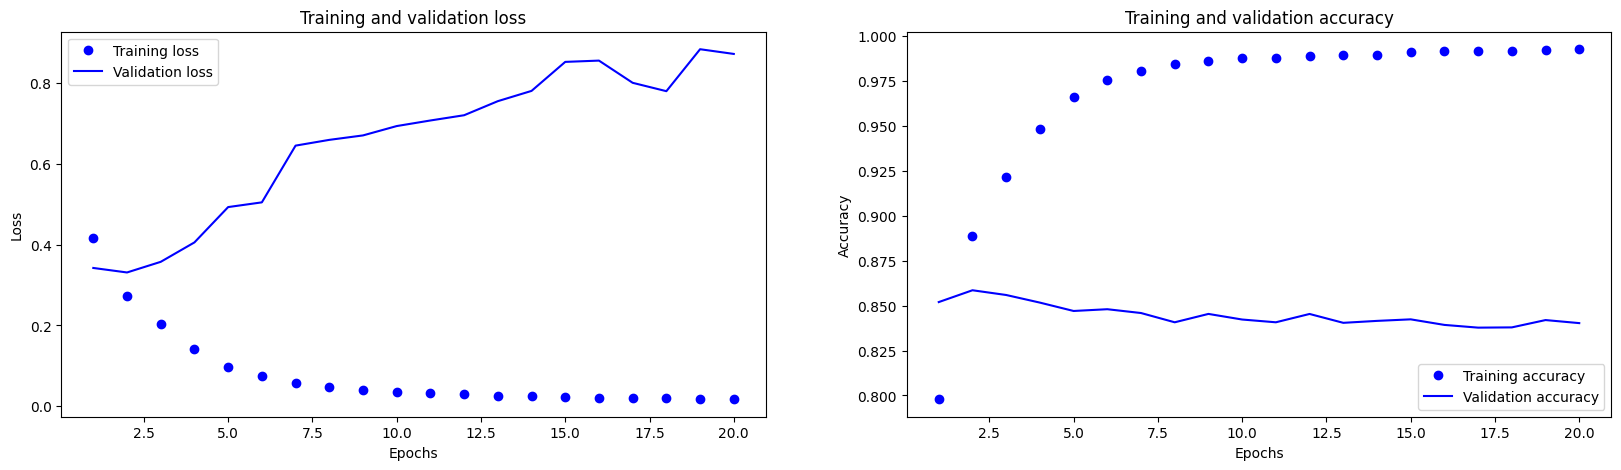

In [37]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
plt.figure(figsize=(20,5))
# "bo"는 "파란색 점"입니다
plt.subplot(1,2,1)
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs, acc, 'bo', label='Training accuracy')
# b는 "파란 실선"입니다
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [38]:
print(results1)
print(results2)
print(results3)
print(results4)

[1.4585267305374146, 0.7369242310523987]
[0.812694787979126, 0.837530255317688]
[0.990653395652771, 0.8290497660636902]
[0.8716568946838379, 0.8402704000473022]


모델들을 학습시켜본 결과 모두 학습을 시작한지 얼마 안되서 과적합이 되는지 val_loss가 증가하고 val_accuracy 감소하는 모습을 보인다.  
그 경향은 모든 모델들에게 공통적으로 발생하는 모습을 볼 수 있다.

따라서 모델을 학습시킬때 과적합을 방지하기 위한 수단을 적용해서 학습을 해야겠다고 생각했다.  
다만, 모든 모델들을 테스트 해볼순 없으니 하나의 모델만으로 테스트 해보기로 정했다.  
model2의 경우 val_accuracy도 나쁘지 않고 학습을 하는데 걸리는 시간이 짧아 적합하다고 판단되어 해당 모델에 과적합 방지 수단을 적용후 다시 학습을 시켜보기로 한다.

In [39]:
from tensorflow.keras import regularizers

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(num_words, word_vector_dim, input_shape=(maxlen,)))
model.add(tf.keras.layers.GlobalMaxPooling1D())
model.add(tf.keras.layers.Dense(8, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 120, 200)          4000000   
                                                                 
 global_max_pooling1d_2 (Glo  (None, 200)              0         
 balMaxPooling1D)                                                
                                                                 
 dense_10 (Dense)            (None, 8)                 1608      
                                                                 
 dropout (Dropout)           (None, 8)                 0         
                                                                 
 dense_11 (Dense)            (None, 1)                 9         
                                                                 
Total params: 4,001,617
Trainable params: 4,001,617
Non-trainable params: 0
____________________________________________

In [40]:
from tensorflow.keras.callbacks import EarlyStopping

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 
early_stopping = EarlyStopping(monitor='val_loss', patience=3)
history = model.fit(X_train_pad,
                    y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_split=0.2,
                    callbacks=[early_stopping],
                    verbose=1)

Epoch 1/20
235/235 [==============================] - 21s 86ms/step - loss: 0.5513 - accuracy: 0.7421 - val_loss: 0.3988 - val_accuracy: 0.8446
Epoch 2/20
235/235 [==============================] - 9s 38ms/step - loss: 0.4072 - accuracy: 0.8370 - val_loss: 0.3634 - val_accuracy: 0.8553
Epoch 3/20
235/235 [==============================] - 6s 23ms/step - loss: 0.3585 - accuracy: 0.8617 - val_loss: 0.3540 - val_accuracy: 0.8591
Epoch 4/20
235/235 [==============================] - 5s 21ms/step - loss: 0.3205 - accuracy: 0.8800 - val_loss: 0.3533 - val_accuracy: 0.8583
Epoch 5/20
235/235 [==============================] - 4s 15ms/step - loss: 0.2898 - accuracy: 0.8934 - val_loss: 0.3587 - val_accuracy: 0.8570
Epoch 6/20
235/235 [==============================] - 3s 11ms/step - loss: 0.2615 - accuracy: 0.9073 - val_loss: 0.3692 - val_accuracy: 0.8553
Epoch 7/20
235/235 [==============================] - 3s 12ms/step - loss: 0.2359 - accuracy: 0.9179 - val_loss: 0.3841 - val_accuracy: 0.854

In [41]:
results5 = model.evaluate(X_test_pad,  y_test, verbose=2)

print(results5)

1563/1563 - 5s - loss: 0.3942 - accuracy: 0.8511 - 5s/epoch - 3ms/step
[0.39420345425605774, 0.8510510921478271]


In [42]:
history_dict = history.history
print(history_dict.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


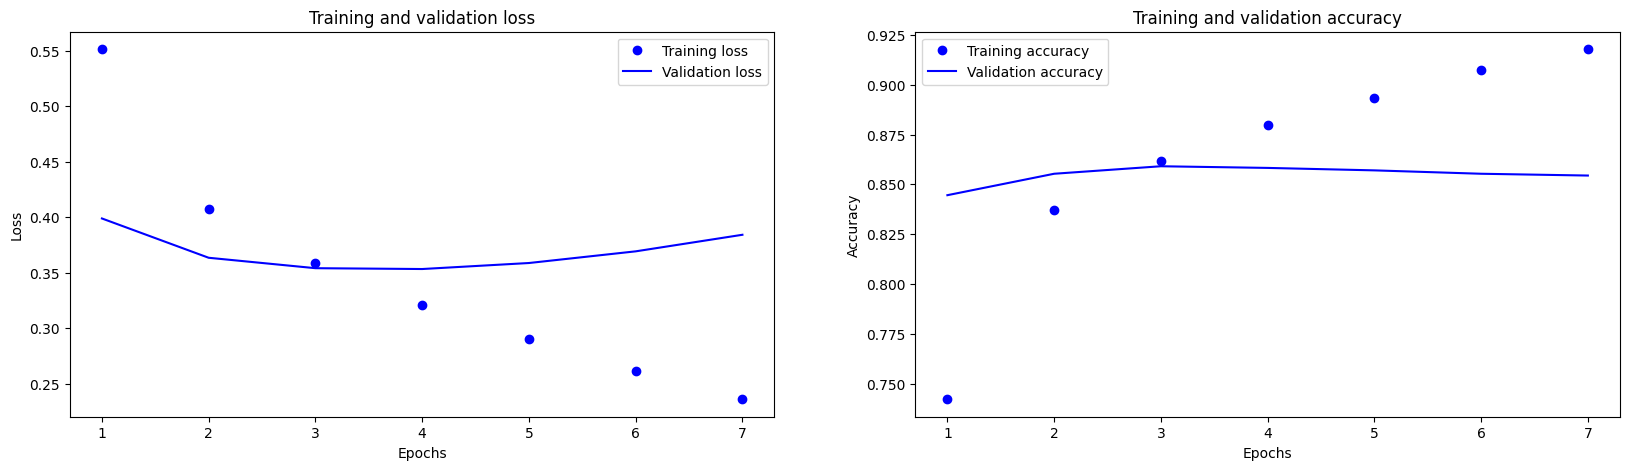

In [43]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
plt.figure(figsize=(20,5))
# "bo"는 "파란색 점"입니다
plt.subplot(1,2,1)
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs, acc, 'bo', label='Training accuracy')
# b는 "파란 실선"입니다
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

테스트 결과 정확도도 85%를 상회하여 나쁘지 않다고 생각된다.

이제 기존의 word2vec 모델을 이용하여 성능이 증가하는지 확인해보도록 한다.

https://drive.google.com/file/d/0B0ZXk88koS2KbDhXdWg1Q2RydlU/view  
모델은 위의 url에서 받은 word2vector 모델을 사용하도록 한다.

In [44]:
import gensim

wordvec = gensim.models.Word2Vec.load('./ko.bin')

In [45]:
wordvec.similar_by_word("재미")

/tmp/ipykernel_32661/3306445457.py:1: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  wordvec.similar_by_word("재미")


[('취미', 0.5857348442077637),
 ('유머', 0.5140613913536072),
 ('매력', 0.5105490684509277),
 ('흥미', 0.4988338351249695),
 ('공짜', 0.4960595667362213),
 ('일자리', 0.49294644594192505),
 ('즐거움', 0.48700767755508423),
 ('비애', 0.4836210310459137),
 ('관객', 0.48286449909210205),
 ('향수', 0.4823310971260071)]

In [46]:
wordvec.similar_by_word("쓰레기")

/tmp/ipykernel_32661/3733885273.py:1: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  wordvec.similar_by_word("쓰레기")


[('폐수', 0.69206702709198),
 ('폐기물', 0.6601318120956421),
 ('처리장', 0.6382778882980347),
 ('지하수', 0.6378296613693237),
 ('음식물', 0.6149210929870605),
 ('식수', 0.6053382754325867),
 ('사체', 0.6005716919898987),
 ('냉각수', 0.5760103464126587),
 ('하수', 0.5734854340553284),
 ('빗물', 0.5625427961349487)]

In [47]:
from tensorflow.keras.initializers import Constant

embedding_matrix = np.random.rand(num_words, word_vector_dim)

# embedding_matrix에 Word2Vec 워드 벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,num_words):
    if index_to_word[i] in wordvec:
        embedding_matrix[i] = wordvec[index_to_word[i]]

/tmp/ipykernel_32661/3171261648.py:7: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  if index_to_word[i] in wordvec:
/tmp/ipykernel_32661/3171261648.py:8: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  embedding_matrix[i] = wordvec[index_to_word[i]]


In [48]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(num_words, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  #카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))
model.add(tf.keras.layers.GlobalMaxPooling1D())
model.add(tf.keras.layers.Dense(8, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 120, 200)          4000000   
                                                                 
 global_max_pooling1d_3 (Glo  (None, 200)              0         
 balMaxPooling1D)                                                
                                                                 
 dense_12 (Dense)            (None, 8)                 1608      
                                                                 
 dropout_1 (Dropout)         (None, 8)                 0         
                                                                 
 dense_13 (Dense)            (None, 1)                 9         
                                                                 
Total params: 4,001,617
Trainable params: 4,001,617
Non-trainable params: 0
____________________________________________

In [49]:
from tensorflow.keras.callbacks import EarlyStopping

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 
early_stopping = EarlyStopping(monitor='val_loss', patience=3)
history = model.fit(X_train_pad,
                    y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_split=0.2,
                    callbacks=[early_stopping],
                    verbose=1)

Epoch 1/20
235/235 [==============================] - 20s 82ms/step - loss: 0.7048 - accuracy: 0.5163 - val_loss: 0.6765 - val_accuracy: 0.6275
Epoch 2/20
235/235 [==============================] - 9s 37ms/step - loss: 0.6558 - accuracy: 0.5884 - val_loss: 0.6092 - val_accuracy: 0.7113
Epoch 3/20
235/235 [==============================] - 7s 29ms/step - loss: 0.6172 - accuracy: 0.6302 - val_loss: 0.5529 - val_accuracy: 0.7477
Epoch 4/20
235/235 [==============================] - 4s 18ms/step - loss: 0.5799 - accuracy: 0.6793 - val_loss: 0.5081 - val_accuracy: 0.7730
Epoch 5/20
235/235 [==============================] - 3s 12ms/step - loss: 0.5531 - accuracy: 0.7063 - val_loss: 0.4808 - val_accuracy: 0.7851
Epoch 6/20
235/235 [==============================] - 4s 17ms/step - loss: 0.5318 - accuracy: 0.7233 - val_loss: 0.4671 - val_accuracy: 0.7954
Epoch 7/20
235/235 [==============================] - 3s 12ms/step - loss: 0.5171 - accuracy: 0.7357 - val_loss: 0.4496 - val_accuracy: 0.803

In [50]:
results6 = model.evaluate(X_test_pad,  y_test, verbose=2)

print(results6)

1563/1563 - 5s - loss: 0.4064 - accuracy: 0.8278 - 5s/epoch - 3ms/step
[0.4063974618911743, 0.8278096914291382]


In [51]:
history_dict = history.history
print(history_dict.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


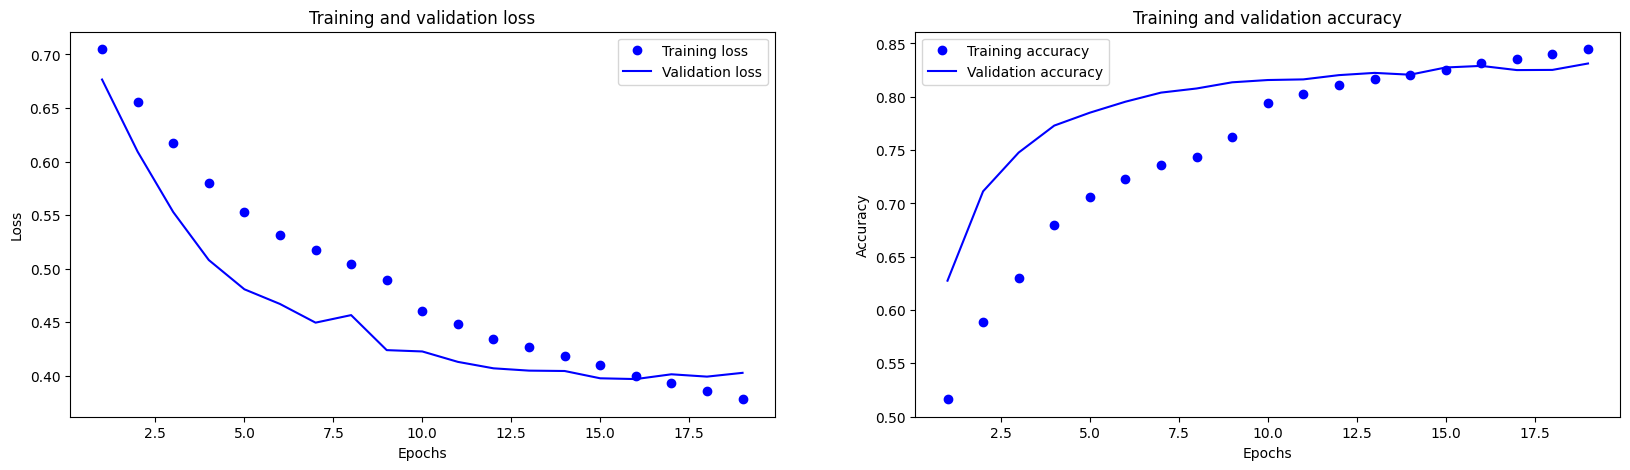

In [52]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
plt.figure(figsize=(20,5))
# "bo"는 "파란색 점"입니다
plt.subplot(1,2,1)
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs, acc, 'bo', label='Training accuracy')
# b는 "파란 실선"입니다
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [53]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(num_words, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  #카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))
model.add(tf.keras.layers.GlobalMaxPooling1D())
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 120, 200)          4000000   
                                                                 
 global_max_pooling1d_4 (Glo  (None, 200)              0         
 balMaxPooling1D)                                                
                                                                 
 dense_14 (Dense)            (None, 8)                 1608      
                                                                 
 dense_15 (Dense)            (None, 1)                 9         
                                                                 
Total params: 4,001,617
Trainable params: 4,001,617
Non-trainable params: 0
_________________________________________________________________


In [54]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=50  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5)
history = model.fit(X_train_pad,
                    y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_split=0.2,
                    callbacks=[early_stopping],
                    verbose=1)

Epoch 1/50
235/235 [==============================] - 20s 80ms/step - loss: 0.6485 - accuracy: 0.6215 - val_loss: 0.5830 - val_accuracy: 0.6944
Epoch 2/50
235/235 [==============================] - 11s 46ms/step - loss: 0.5426 - accuracy: 0.7256 - val_loss: 0.5217 - val_accuracy: 0.7420
Epoch 3/50
235/235 [==============================] - 5s 23ms/step - loss: 0.4848 - accuracy: 0.7668 - val_loss: 0.4776 - val_accuracy: 0.7719
Epoch 4/50
235/235 [==============================] - 4s 17ms/step - loss: 0.4431 - accuracy: 0.7935 - val_loss: 0.4526 - val_accuracy: 0.7898
Epoch 5/50
235/235 [==============================] - 4s 17ms/step - loss: 0.4120 - accuracy: 0.8113 - val_loss: 0.4332 - val_accuracy: 0.8011
Epoch 6/50
235/235 [==============================] - 3s 14ms/step - loss: 0.3861 - accuracy: 0.8272 - val_loss: 0.4215 - val_accuracy: 0.8062
Epoch 7/50
235/235 [==============================] - 3s 13ms/step - loss: 0.3648 - accuracy: 0.8391 - val_loss: 0.4163 - val_accuracy: 0.81

In [55]:
results7 = model.evaluate(X_test_pad,  y_test, verbose=2)

print(results7)

1563/1563 - 4s - loss: 0.4646 - accuracy: 0.8235 - 4s/epoch - 3ms/step
[0.46461936831474304, 0.8234894275665283]


In [56]:
history_dict = history.history
print(history_dict.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


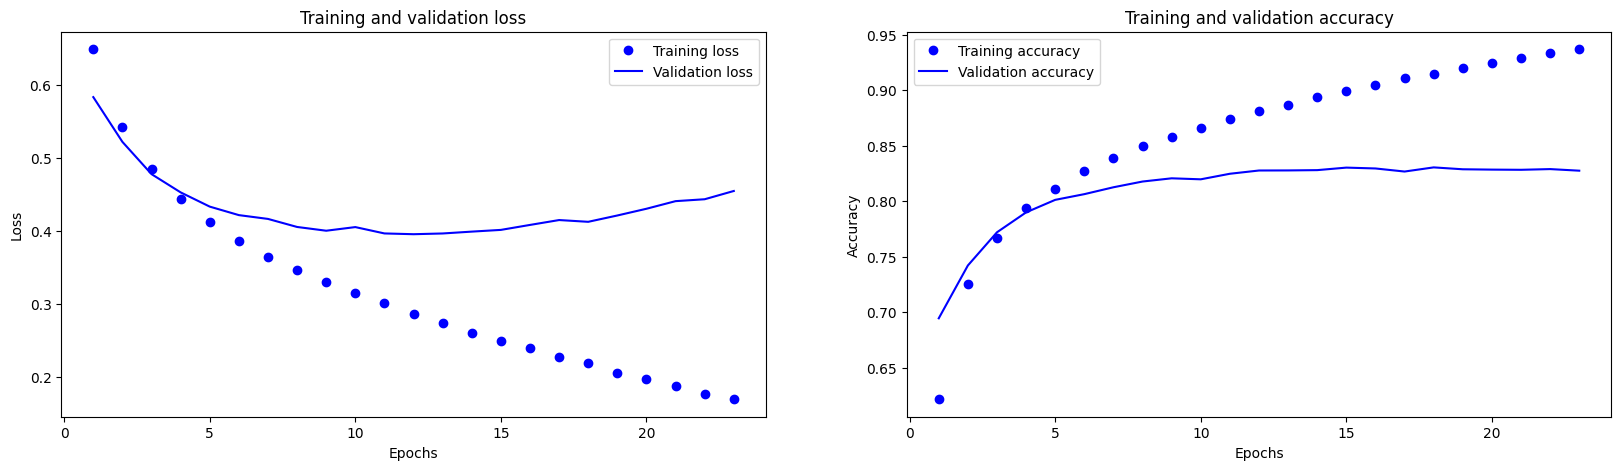

In [57]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
plt.figure(figsize=(20,5))
# "bo"는 "파란색 점"입니다
plt.subplot(1,2,1)
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs, acc, 'bo', label='Training accuracy')
# b는 "파란 실선"입니다
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [58]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(num_words, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  #카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))
model.add(tf.keras.layers.MaxPooling1D(5))
model.add(tf.keras.layers.LSTM(128))
model.add(tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(tf.keras.layers.Reshape((64, 1)))
model.add(tf.keras.layers.LSTM(32))
model.add(tf.keras.layers.Dense(16, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 120, 200)          4000000   
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 24, 200)          0         
 1D)                                                             
                                                                 
 lstm_2 (LSTM)               (None, 128)               168448    
                                                                 
 dense_16 (Dense)            (None, 64)                8256      
                                                                 
 reshape_2 (Reshape)         (None, 64, 1)             0         
                                                                 
 lstm_3 (LSTM)               (None, 32)                4352      
                                                      

2023-04-18 18:41:58.816584: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-18 18:41:58.817834: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-18 18:41:58.818837: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [59]:
from tensorflow.keras.callbacks import EarlyStopping

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5)
history = model.fit(X_train_pad,
                    y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_split=0.2,
                    callbacks=[early_stopping],
                    verbose=1)

Epoch 1/20


2023-04-18 18:41:59.224861: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-18 18:41:59.226447: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-18 18:41:59.227421: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

235/235 [==============================] - ETA: 0s - loss: 0.6154 - accuracy: 0.6906

2023-04-18 18:42:21.019032: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-18 18:42:21.020313: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-18 18:42:21.021593: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

235/235 [==============================] - 23s 85ms/step - loss: 0.6154 - accuracy: 0.6906 - val_loss: 0.5128 - val_accuracy: 0.7695
Epoch 2/20
235/235 [==============================] - 11s 49ms/step - loss: 0.4666 - accuracy: 0.7940 - val_loss: 0.4404 - val_accuracy: 0.8087
Epoch 3/20
235/235 [==============================] - 7s 30ms/step - loss: 0.4000 - accuracy: 0.8314 - val_loss: 0.4199 - val_accuracy: 0.8181
Epoch 4/20
235/235 [==============================] - 6s 25ms/step - loss: 0.3525 - accuracy: 0.8554 - val_loss: 0.3897 - val_accuracy: 0.8363
Epoch 5/20
235/235 [==============================] - 5s 22ms/step - loss: 0.3185 - accuracy: 0.8726 - val_loss: 0.3692 - val_accuracy: 0.8444
Epoch 6/20
235/235 [==============================] - 5s 22ms/step - loss: 0.2899 - accuracy: 0.8873 - val_loss: 0.3698 - val_accuracy: 0.8471
Epoch 7/20
235/235 [==============================] - 5s 20ms/step - loss: 0.2592 - accuracy: 0.9019 - val_loss: 0.3941 - val_accuracy: 0.8399
Epoch 8/

In [60]:
results8 = model.evaluate(X_test_pad,  y_test, verbose=2)

print(results8)

1563/1563 - 8s - loss: 0.4862 - accuracy: 0.8356 - 8s/epoch - 5ms/step
[0.4861796796321869, 0.835590124130249]


In [61]:
history_dict = history.history
print(history_dict.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


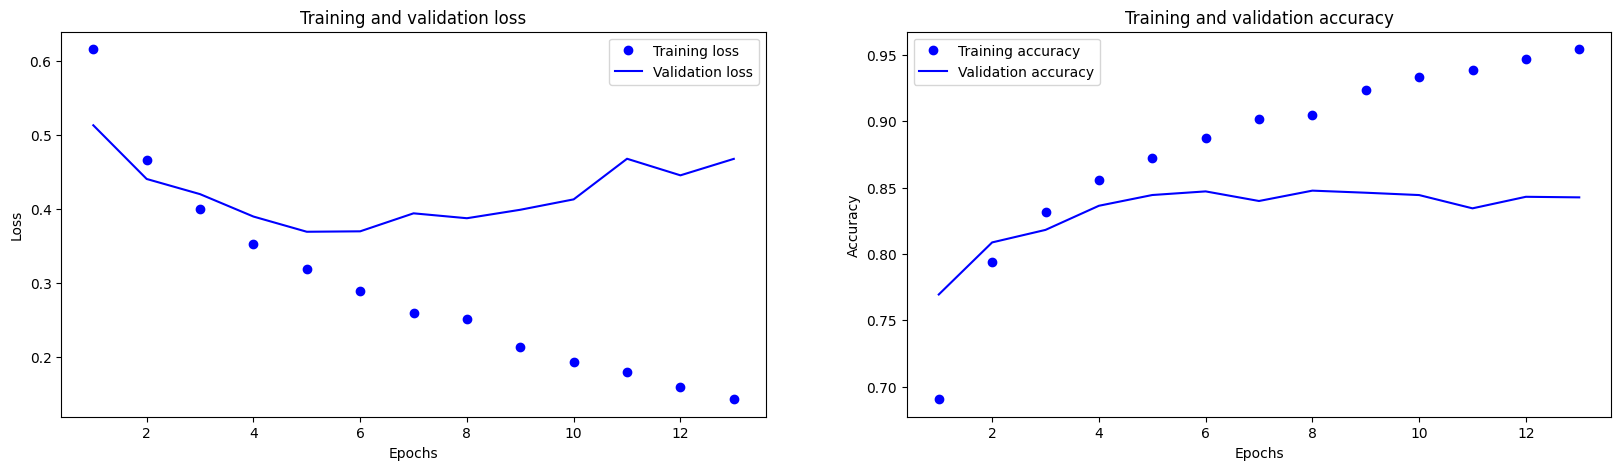

In [62]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
plt.figure(figsize=(20,5))
# "bo"는 "파란색 점"입니다
plt.subplot(1,2,1)
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs, acc, 'bo', label='Training accuracy')
# b는 "파란 실선"입니다
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [63]:
print(results1)
print(results2)
print(results3)
print(results4)
print(results5)
print(results6)
print(results7)
print(results8)

[1.4585267305374146, 0.7369242310523987]
[0.812694787979126, 0.837530255317688]
[0.990653395652771, 0.8290497660636902]
[0.8716568946838379, 0.8402704000473022]
[0.39420345425605774, 0.8510510921478271]
[0.4063974618911743, 0.8278096914291382]
[0.46461936831474304, 0.8234894275665283]
[0.4861796796321869, 0.835590124130249]


기존의 모델을 활용하여 학습을 진행하니 이전보다 학습 속도가 원만히 증가하는 모습을 볼 수 있다.  
하지만 전체적인 모델들의 성능 자체는 나아진 모습을 보이진 않고 있다.  

정확한 이유는 여러모로 찾아봤으나 정확한 이유는 찾을수 없었다.  
다만 예상하기로는 해당 모델은 이전 데이터에서 학습된 매개 변수와 하이퍼 파라미터를 사용하므로 현재 작업과 맞지 않아 발생한게 아닌가 추측해본다.

이번 학습을 하면서 gensim 라이브러리를 사용하는데 약간 애를 먹었다.
pre-trained 모델을 다운받아서 사용하는데, 해당 모델을 학습시킬때는 gensim 버전이 3이었으나 내가 받은 것은 최신버전인 4 이상의 버전이었다.  
그래서 기존의 gensim 버전을 다운그레이드를 해야했다.


근데 gensim 버전이 3에서 4로 올라오면서 라이브러리의 함수가 있는 라이브러리가 바뀌어, 해당 라이브러리의 코드에서 import 하는 부분의 코드들을 전부 수정해주어야지만 사용할 수 있었다.
손은 많이 갔지만 이런식으로도 해결할 수 있다는 좋은 경험이었다.